# YOLO Model을 활용한 주차공간 탐지

- AI-Hub 데이터만을 사용

## YOLOv5 모델 (PyTorch)

* https://github.com/ultralytics/yolov5
* https://www.ultralytics.com

YOLOv5 모델 다운로드

In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

import torch
from IPython.display import Image, clear_output

Cloning into 'yolov5'...
remote: Enumerating objects: 17045, done.
remote: Counting objects: 100% (23/23), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 17045 (delta 10), reused 18 (delta 8), pack-reused 17022 (from 1)
Receiving objects: 100% (17045/17045), 15.66 MiB | 13.41 MiB/s, done.
Resolving deltas: 100% (11700/11700), done.
/content/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 19.6 MB/s eta 0:00:00


In [ ]:
# 파일 및 디렉토리 작업을 위한 라이브러리
import os
import glob

# 난수 생성을 위한 라이브러리
import random

# 배열 및 행렬 작업을 위한 라이브러리
import numpy as np

# 데이터 시각화를 위한 라이브러리
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# HTML 파싱을 위한 라이브러리
from bs4 import BeautifulSoup

# 이미지 처리를 위한 라이브러리
from PIL import Image

# 딥러닝 프레임워크
import torch
import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# 시간 측정을 위한 라이브러리
import time

# 작업 진행 상황을 시각적으로 보여주는 라이브러리
from tqdm import tqdm

# 경고 메시지 무시
import warnings
warnings.filterwarnings('ignore')

# 0. 데이터셋 준비

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import json
from PIL import Image

# 데이터셋 루트 디렉토리 설정
dataset_root = "/content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset"

In [ ]:
# 클래스 매핑
class_mapping = {
    "Disabled Parking Space": 0,
    "Electric Car Parking Space": 1,
    "Parking Space": 2
}

YOLO 모델 사용을 위한 json파일 txt로 바꾸기

In [ ]:
# 데이터셋 루트 디렉토리 설정
dataset_root = "/content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset"

# train, validation, test 폴더 순회
for split in ["train", "validation", "test"]:
    label_dir = os.path.join(dataset_root, split, "labels")
    image_dir = os.path.join(dataset_root, split, "images")

    for json_file_name in os.listdir(label_dir):
        if json_file_name.endswith(".json"):
            json_path = os.path.join(label_dir, json_file_name)

            # 이미지 파일 이름에서 "filtered_" 제거
            img_base_name = json_file_name.replace("filtered_", "").replace(".json", ".jpg")
            image_path = os.path.join(image_dir, img_base_name)
            txt_path = os.path.join(label_dir, json_file_name.replace(".json", ".txt"))

            try:
                # 이미지 크기 가져오기
                with Image.open(image_path) as img:
                    image_width, image_height = img.size
            except FileNotFoundError:
                print(f"Image file not found for JSON: {json_path}")
                continue  # 이미지가 없으면 해당 파일은 건너뜀

            # JSON 파일 읽기
            with open(json_path, 'r') as json_file:
                data = json.load(json_file)

            # YOLO 형식의 .txt 파일 생성
            with open(txt_path, 'w') as txt_file:
                # bbox2d 객체 처리
                if "bbox2d" in data:
                    for item in data["bbox2d"]:
                        class_name = item.get("name")
                        if class_name in class_mapping:
                            class_id = class_mapping[class_name]
                            x_min, y_min, x_max, y_max = item["bbox"]
                            x_center = (x_min + x_max) / 2.0 / image_width
                            y_center = (y_min + y_max) / 2.0 / image_height
                            width = (x_max - x_min) / image_width
                            height = (y_max - y_min) / image_height
                            txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

                # segmentation 객체 처리 (세그멘테이션 좌표를 bounding box로 변환)
                if "segmentation" in data:
                    for item in data["segmentation"]:
                        if item.get("name") in class_mapping:
                            class_id = class_mapping[item.get("name")]
                            polygon = item["polygon"]
                            x_coords = [point[0] for point in polygon]
                            y_coords = [point[1] for point in polygon]
                            x_min, x_max = min(x_coords), max(x_coords)
                            y_min, y_max = min(y_coords), max(y_coords)
                            x_center = (x_min + x_max) / 2.0 / image_width
                            y_center = (y_min + y_max) / 2.0 / image_height
                            width = (x_max - x_min) / image_width
                            height = (y_max - y_min) / image_height
                            txt_file.write(f"{class_id} {x_center} {y_center} {width} {height}\n")

yaml 파일 만들기

In [ ]:
data_yaml = """
train: /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/train/images
val: /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/validation/images
test: /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/test/images

nc: 3
names: ['Disabled Parking Space', 'Electric Car Parking Space', 'Parking Space']

"""

# yolo_data 폴더 경로 생성 (없으면 생성)
yolo_data_path = os.path.join(dataset_root, "yolo_data")
os.makedirs(yolo_data_path, exist_ok=True)

# data.yaml 파일 저장
yaml_file_path = os.path.join(yolo_data_path, 'data.yaml')

with open(yaml_file_path, 'w') as f:
    f.write(data_yaml)

In [ ]:
print(f"data.yaml has been saved to: {yaml_file_path}")

data.yaml has been saved to: /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/yolo_data/data.yaml


In [ ]:
!nvidia-smi

Sat Nov  9 12:04:26 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### 검증(Validation)

In [ ]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/yolo_data/data.yaml --img 640 --iou 0.65 --half

val: data=/content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/yolo_data/data.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.65, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=True, dnn=False
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/validation/labels.cache... 7 images, 0 backgrounds, 0 corrupt: 100% 7/7 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95:   0% 0/1 [00:00<?, ?it/s]WARNING ⚠️ NMS time limit 0.850s exceeded
                 Class     Images  In

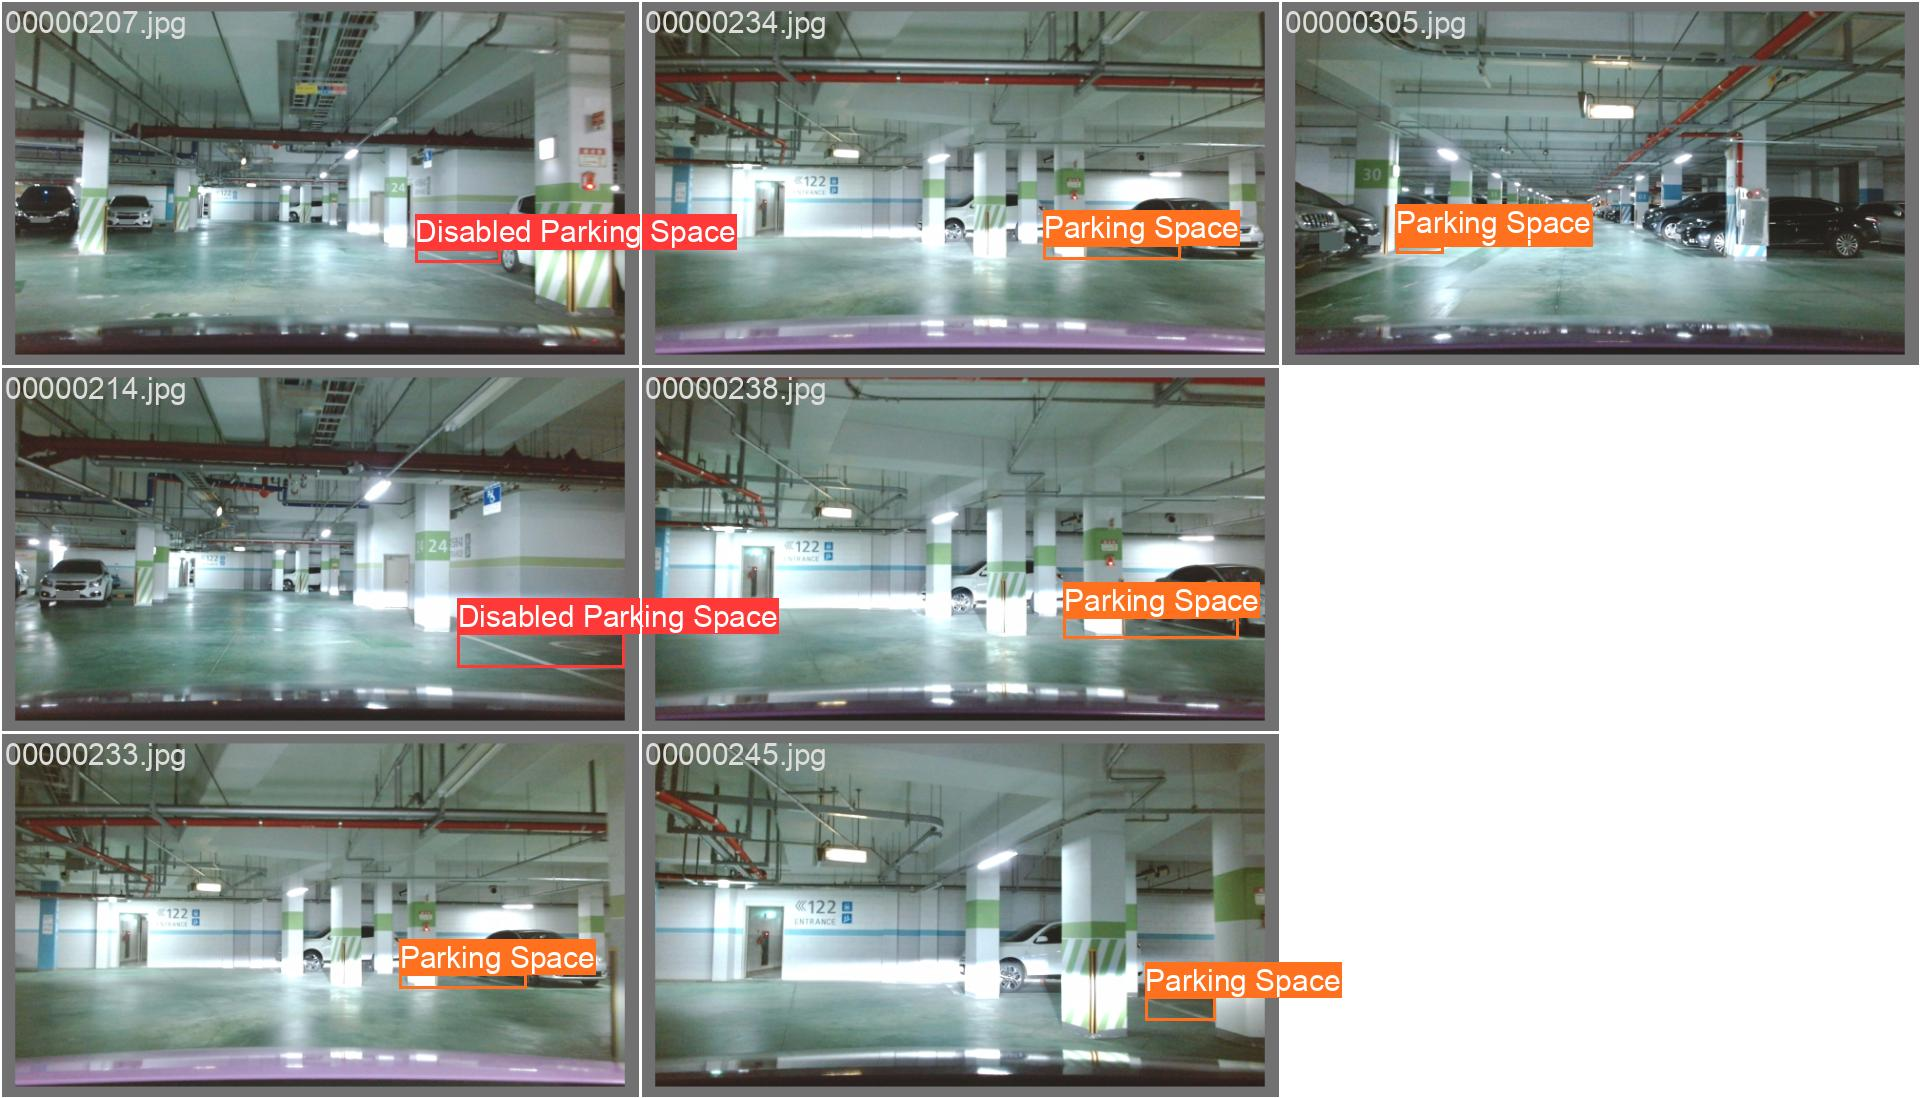

In [ ]:
Image(filename='/content/yolov5/runs/val/exp/val_batch0_labels.jpg', width=1000)

In [ ]:
!python val.py --weights /content/yolov5/runs/train/exp2/weights/best.pt --data /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/yolo_data/data.yaml --img 640 --task test

val: data=/content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/yolo_data/data.yaml, weights=['/content/yolov5/runs/train/exp2/weights/best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=test, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-383-g1435a8ee Python-3.10.12 torch-2.5.0+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
Model summary: 157 layers, 7018216 parameters, 0 gradients, 15.8 GFLOPs
test: Scanning /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/test/labels... 9 images, 0 backgrounds, 0 corrupt: 100% 9/9 [00:00<00:00, 80.91it/s]
test: New cache created: /content/drive/MyDrive/likelion_CV/objectDetection_project/split_dataset/test/labels.cache
                 Class     Images  Instances          P          R      mAP50   

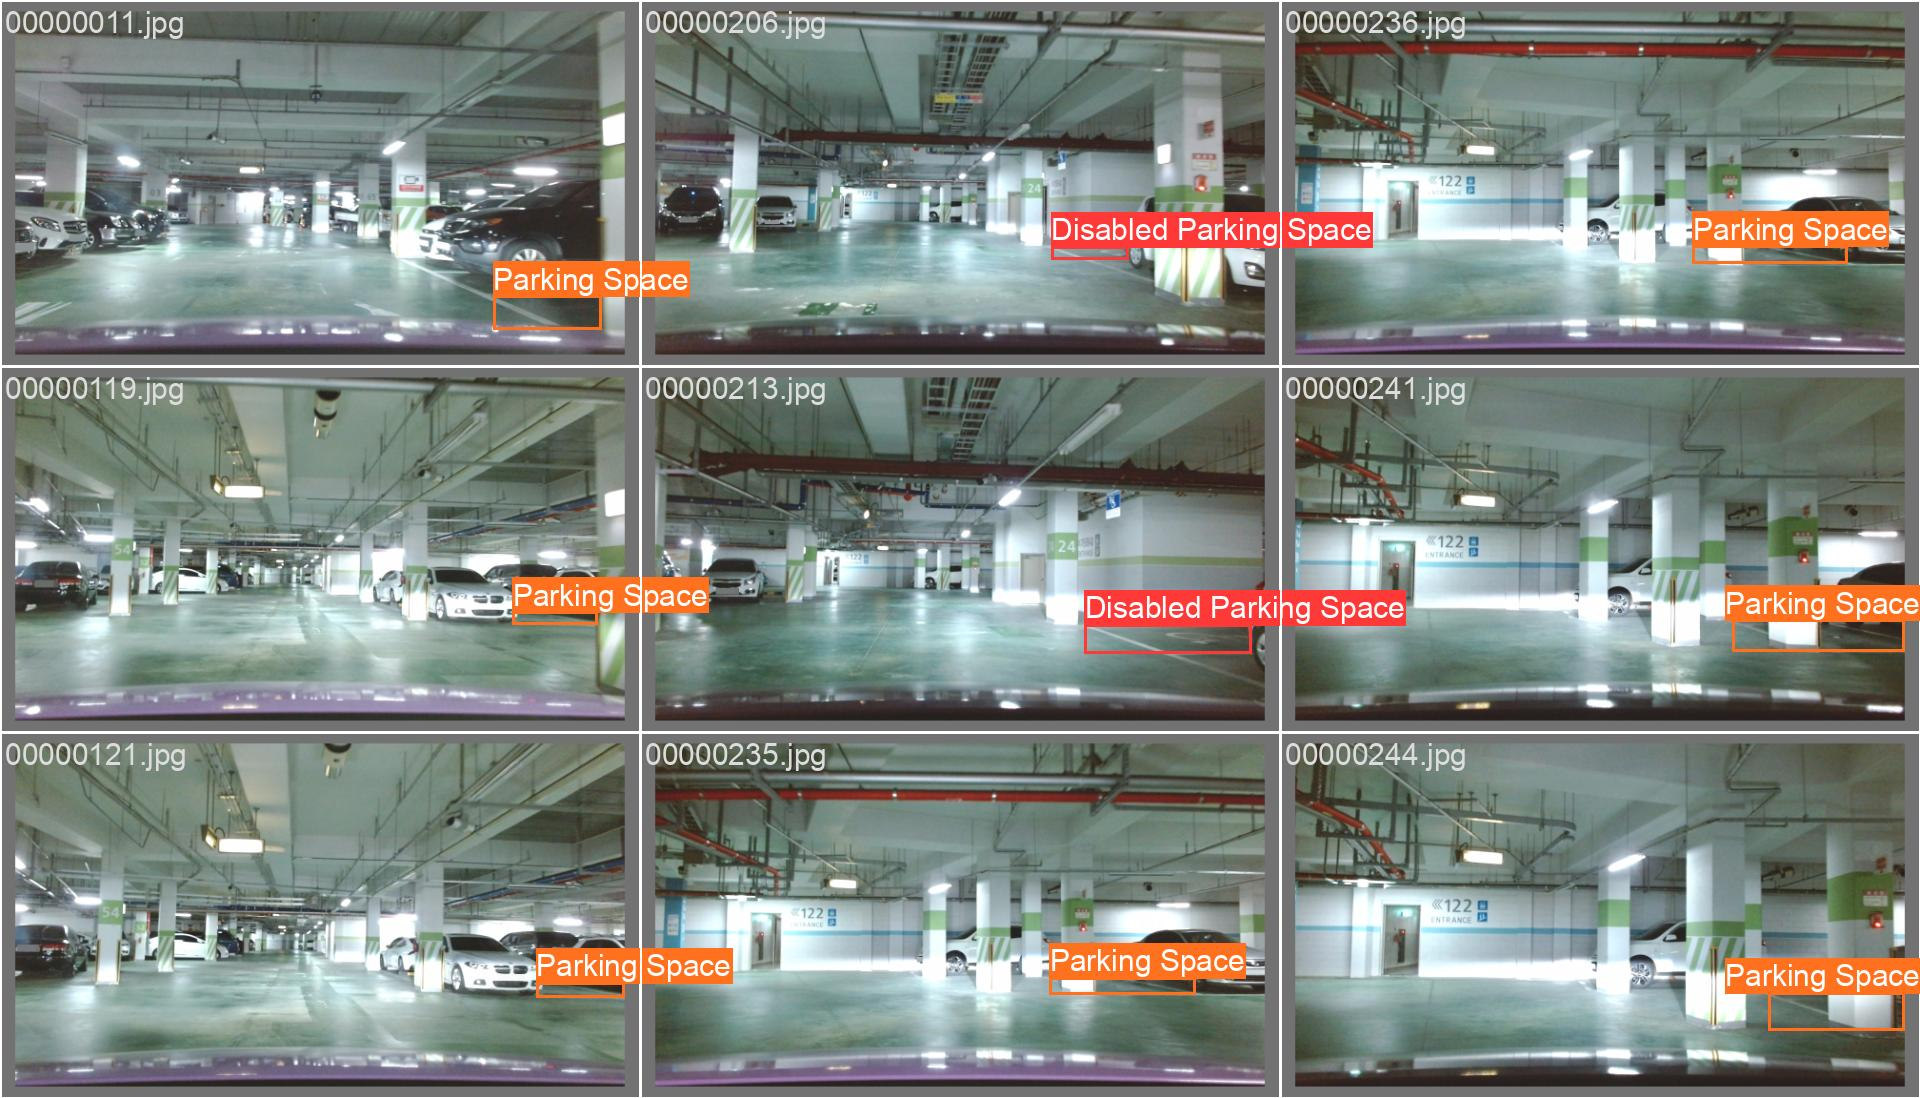

In [ ]:
Image(filename='/content/yolov5/runs/val/exp2/val_batch0_labels.jpg', width=1000)

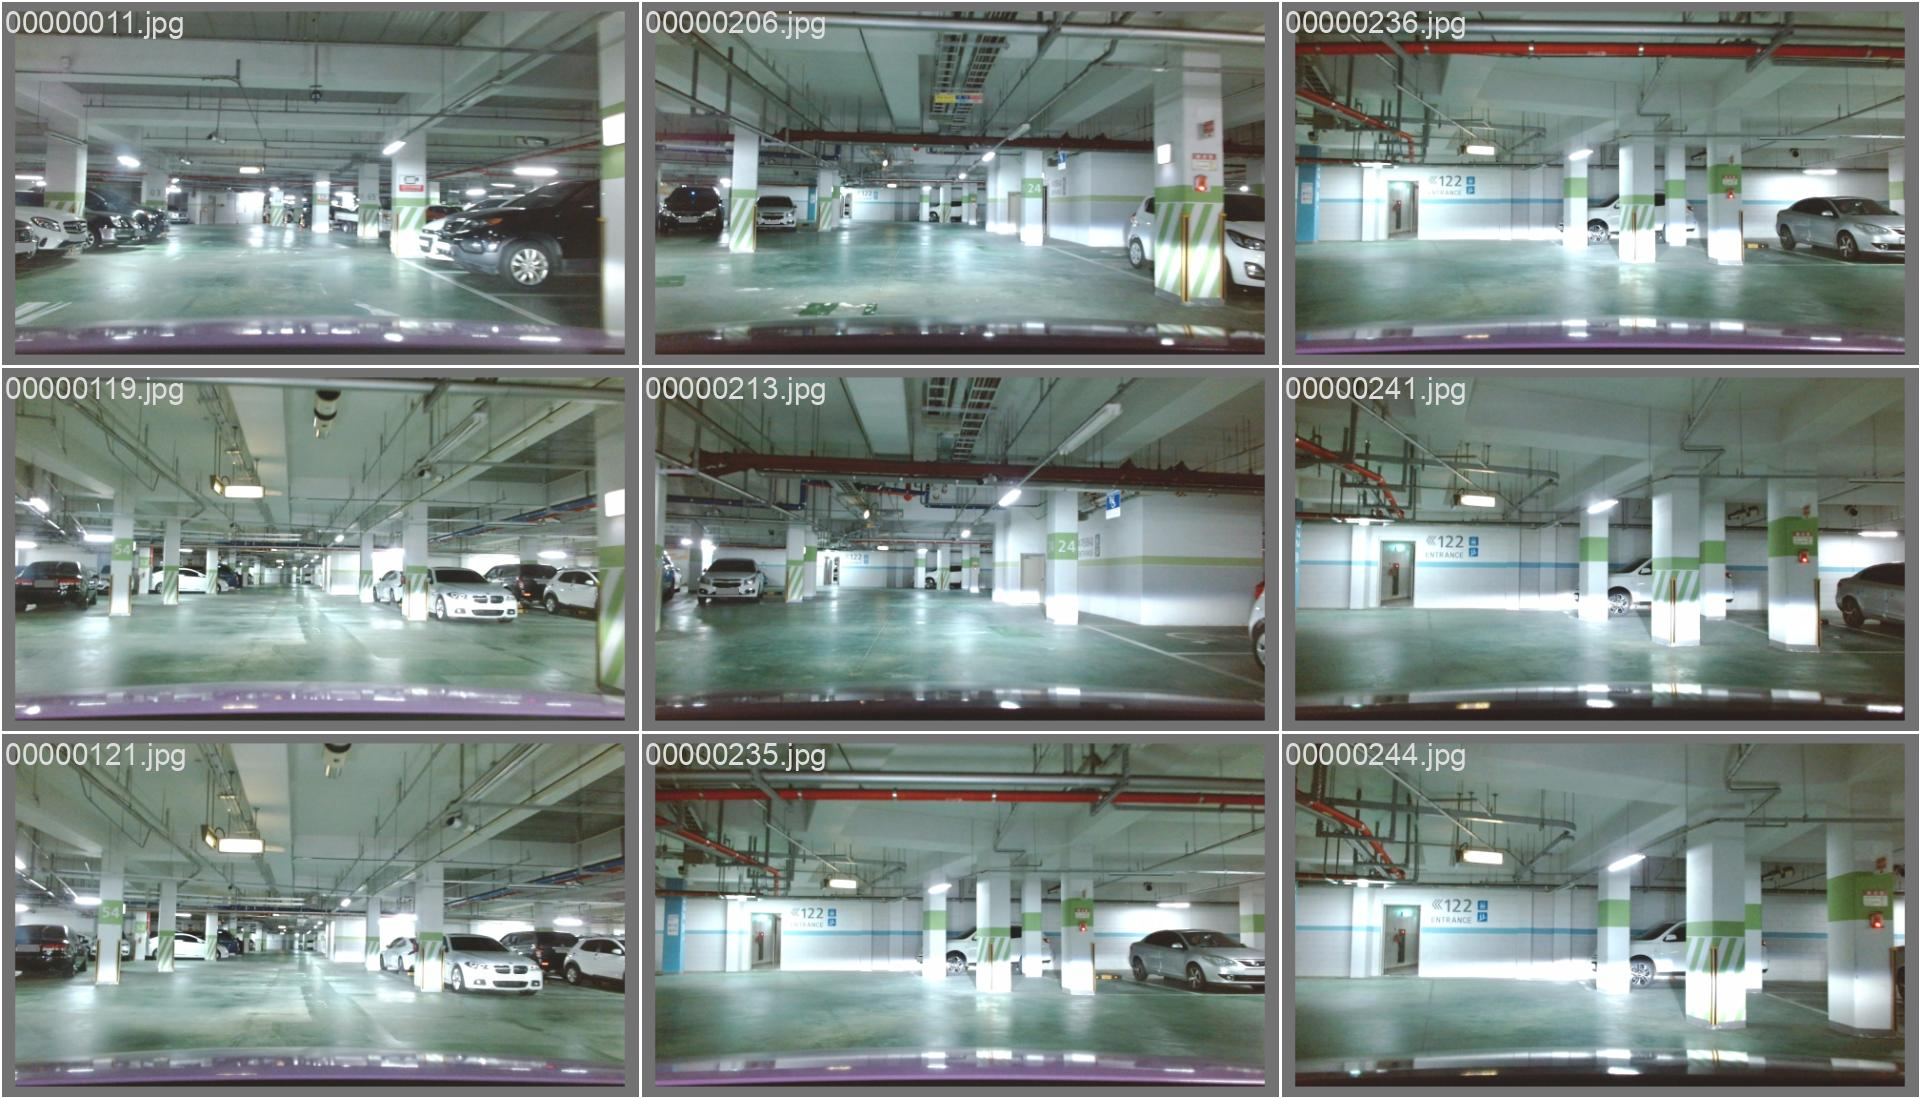

In [ ]:
Image(filename='/content/yolov5/runs/val/exp2/val_batch0_pred.jpg', width=1000)